In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
from scipy.spatial import cKDTree
from scipy.signal import oaconvolve
import cupy as cp
from cupyx import scatter_add

In [3]:
class Sperm2D:
    def __init__(self,
                 length=70.1,
                 n_segments=50,
                 bending_modulus=1800,
                 amplitude=0.2,
                 wavenumber=1.0, # Note: not the conventional wavenumner. 2*pi*k*l/L, where k is the wavenumber
                 frequency=1.0,
                 init_position=[0, 0], # tip of head
                 init_angle=0,
                 phase=0,
                 head_semi_major=3,
                 head_semi_minor=1): # Also the tail radius
        """
        Initialize a single 2D sperm filament.

        Parameters
        ----------
        length : float (default=70.1)
            Total length of the filament (L).
        n_segments : int (default = 50)
            Number of discrete segments (N).
        bending_modulus : float (default = 1800)
            Bending stiffness K_B.
        amplitude, wavenumber, frequency, phase : floats (defaults = 0.2, 1.0, 1.0, 0)
            Parameters for the preferred-curvature waveform kappa(s,t).
        init_position : list of 2 elements
            Initial position of the head tip of sperm
        """
        # Geometry
        self.L = length
        self.N_flag = n_segments
        self.Delta_L = length / n_segments
        self.a = head_semi_major
        self.b = head_semi_minor

        # Mechanical parameters
        self.K_B = bending_modulus
        self.K_0 = amplitude
        self.k = wavenumber
        self.omega = frequency
        self.phi = phase

        # State: positions Y[0..N], angles theta[0..N]
        self.Y_0 = init_position
        self.theta_0 = init_angle
        coordinates = np.hstack([0, self.a, np.arange(2.1*self.a, self.L+2.101*self.a, self.Delta_L/2)]) # Extra 0.1a to account for the linkage between the flagellum and the head
        self.edge_midpoint = np.vstack([self.Y_0[0]+coordinates*np.cos(self.theta_0), self.Y_0[1]+coordinates*np.sin(self.theta_0)]).T # An array of length 2N+3 (midpoint and edges of segmenets)
        self.theta = np.array([init_angle]*(self.N_flag+1)) # An array of length N+1 (midpoint of segments)
        self.Y = self.edge_midpoint[1::2]

        # Lagrange multipliers for constraints (N+2 of them), corresponding to the edges of each segment
        self.Lambda = np.zeros((self.N_flag+2, 2))

    def preferred_curvature(self, t):
        """
        Preferred curvature Kappa(s,t) along filament using Eq. 2.1 of Schoeller et al. 2018
        Returns an array of length N, corresponding to the midpoint of each filament segment only, i.e. no head.
        """
        s = np.arange(self.Delta_L/2, self.L, self.Delta_L)
        base = self.K_0 * np.sin(2*np.pi*self.k*s/self.L - self.omega*t+self.phi)
        decay = np.where(s > self.L/2, 2*(self.L - s)/self.L, 1.0)
        kappa = base * decay
        return kappa

    def internal_moment(self, t):
        """
        Compute M_{n+1/2} for n=1..N+1 using Eq. 34 of Schoeller et al. 2020
        Returns an array of length N+2, corresponding to the edges of each segment.
        """
        kappa = self.preferred_curvature(t)
        t_hat_x, t_hat_y = np.cos(self.theta), np.sin(self.theta)
        cross = t_hat_x[:-1]*t_hat_y[1:] - t_hat_y[:-1]*t_hat_x[1:]
        delta_s = np.zeros(self.N_flag)
        delta_s[0] = 1.1*self.a+self.Delta_L/2
        delta_s[1:] = self.Delta_L
        M = np.zeros(self.N_flag+2)
        M[1:self.N_flag+1] = self.K_B * (cross/delta_s - kappa)
        return M

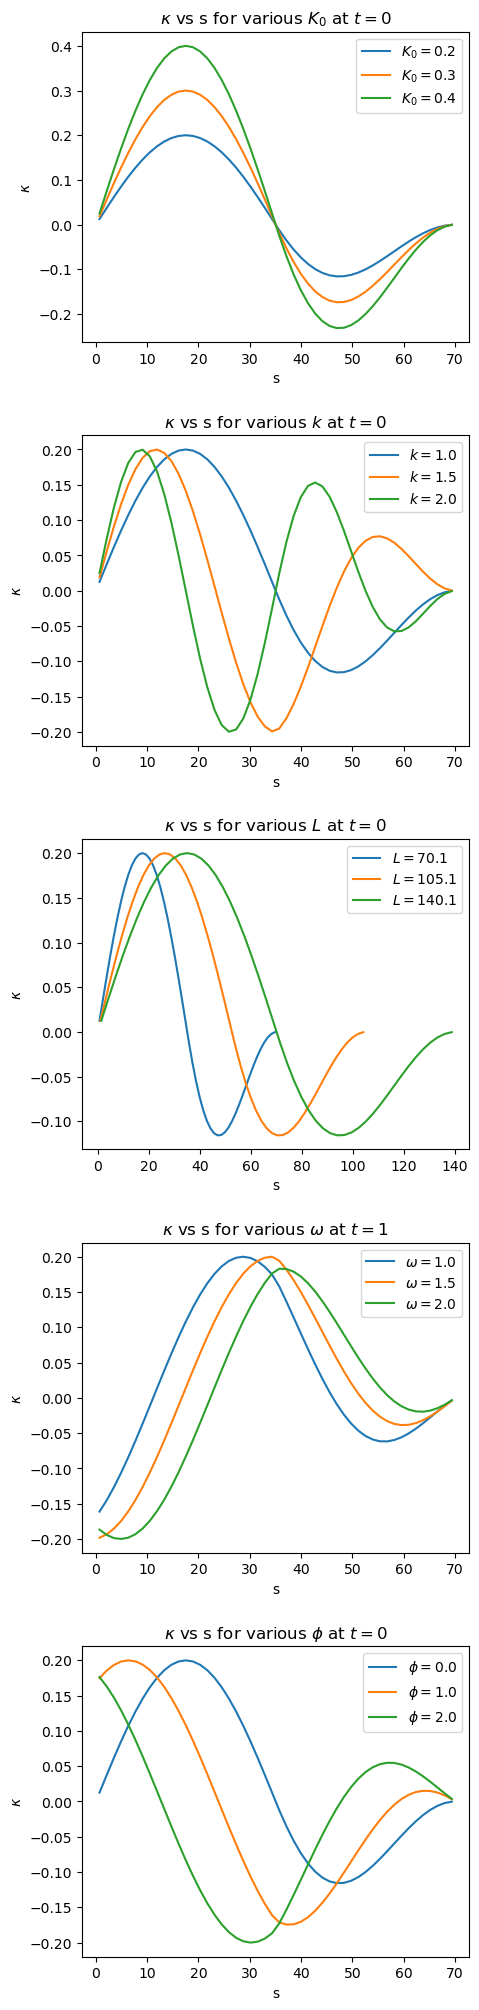

In [4]:
# kappa vs s graphs. Check preferred_curvature method
fig, ax = plt.subplots(5, 1, figsize=(5, 25))
plt.subplots_adjust(hspace=0.3)

# Different K_0
for i in range(3):
    amplitude = 0.2+i*0.1
    sperm = Sperm2D(amplitude=amplitude)
    s = np.arange(sperm.Delta_L/2, sperm.L, sperm.Delta_L)
    kappa = sperm.preferred_curvature(0)
    ax[0].plot(s, kappa, label=f"$K_0={amplitude:.1f}$")
    ax[0].set_title(r'$\kappa$ vs s for various $K_0$ at $t=0$')
    ax[0].set_xlabel('s')
    ax[0].set_ylabel(r'$\kappa$')
    ax[0].legend()

# Different k
for i in range(3):
    wavenumber = 1.0+i*0.5
    sperm = Sperm2D(wavenumber=wavenumber)
    s = np.arange(sperm.Delta_L/2, sperm.L, sperm.Delta_L)
    kappa = sperm.preferred_curvature(0)
    ax[1].plot(s, kappa, label=f"$k={wavenumber:.1f}$")
    ax[1].set_title(r'$\kappa$ vs s for various $k$ at $t=0$')
    ax[1].set_xlabel('s')
    ax[1].set_ylabel(r'$\kappa$')
    ax[1].legend()

# Different L
for i in range(3):
    length = 70.1+i*35
    sperm = Sperm2D(length=length)
    s = np.arange(sperm.Delta_L/2, sperm.L, sperm.Delta_L)
    kappa = sperm.preferred_curvature(0)
    ax[2].plot(s, kappa, label=f"$L={length:.1f}$")
    ax[2].set_title(r'$\kappa$ vs s for various $L$ at $t=0$')
    ax[2].set_xlabel('s')
    ax[2].set_ylabel(r'$\kappa$')
    ax[2].legend()

# Different omega
for i in range(3):
    frequency = 1.0+0.5*i
    sperm = Sperm2D(frequency=frequency)
    s = np.arange(sperm.Delta_L/2, sperm.L, sperm.Delta_L)
    kappa = sperm.preferred_curvature(1)
    ax[3].plot(s, kappa, label=f"$\\omega={frequency:.1f}$")
    ax[3].set_title(r'$\kappa$ vs s for various $\omega$ at $t=1$')
    ax[3].set_xlabel('s')
    ax[3].set_ylabel(r'$\kappa$')
    ax[3].legend()

# Different phi
for i in range(3):
    phase = i
    sperm = Sperm2D(phase=phase)
    s = np.arange(sperm.Delta_L/2, sperm.L, sperm.Delta_L)
    kappa = sperm.preferred_curvature(0)
    ax[4].plot(s, kappa, label=f"$\\phi={phase:.1f}$")
    ax[4].set_title(r'$\kappa$ vs s for various $\phi$ at $t=0$')
    ax[4].set_xlabel('s')
    ax[4].set_ylabel(r'$\kappa$')
    ax[4].legend()

plt.show()

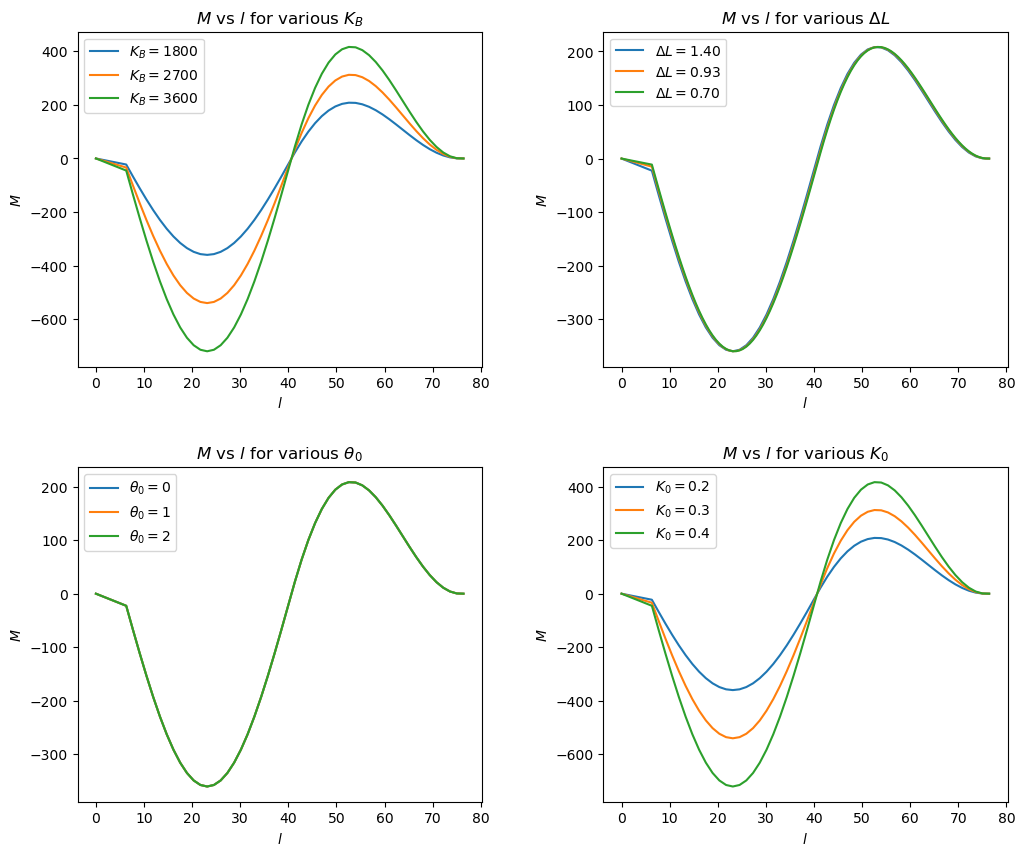

In [5]:
# M vs l graphs. Check internal_moment method
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Different K_B
for i in range(3):
    bending_modulus = 1800+i*900
    sperm = Sperm2D(bending_modulus=bending_modulus)
    l = np.hstack([0, np.arange(2.1*sperm.a, sperm.L+2.101*sperm.a, sperm.Delta_L)])
    M = sperm.internal_moment(0)
    ax[0, 0].plot(l, M, label=f"$K_B={bending_modulus}$")
    ax[0, 0].set_title(r'$M$ vs $l$ for various $K_B$')
    ax[0, 0].set_xlabel(r'$l$')
    ax[0, 0].set_ylabel(r'$M$')
    ax[0, 0].legend()

# Different Delta L
for i in range(3):
    n_segments = 50+25*i
    sperm = Sperm2D(n_segments=n_segments)
    l = np.hstack([0, np.arange(2.1*sperm.a, sperm.L+2.101*sperm.a, sperm.Delta_L)])
    M = sperm.internal_moment(0)
    ax[0, 1].plot(l, M, label=f"$\\Delta L={sperm.Delta_L:.2f}$")
    ax[0, 1].set_title(r'$M$ vs $l$ for various $\Delta L$')
    ax[0, 1].set_xlabel(r'$l$')
    ax[0, 1].set_ylabel(r'$M$')
    ax[0, 1].legend()

# Different init_angle
for i in range(3):
    init_angle = i
    sperm = Sperm2D(init_angle=init_angle)
    l = np.hstack([0, np.arange(2.1*sperm.a, sperm.L+2.101*sperm.a, sperm.Delta_L)])
    M = sperm.internal_moment(0)
    ax[1, 0].plot(l, M, label=f"$\\theta_0={init_angle}$")
    ax[1, 0].set_title(r'$M$ vs $l$ for various $\theta_0$')
    ax[1, 0].set_xlabel(r'$l$')
    ax[1, 0].set_ylabel(r'$M$')
    ax[1, 0].legend()

# Different kappa, varied by varying K_0
for i in range(3):
    amplitude = 0.2+i*0.1
    sperm = Sperm2D(amplitude=amplitude)
    l = np.hstack([0, np.arange(2.1*sperm.a, sperm.L+2.101*sperm.a, sperm.Delta_L)])
    M = sperm.internal_moment(0)
    ax[1, 1].plot(l, M, label=f"$K_0={amplitude:.1f}$")
    ax[1, 1].set_title(r'$M$ vs $l$ for various $K_0$')
    ax[1, 1].set_xlabel(r'$l$')
    ax[1, 1].set_ylabel(r'$M$')
    ax[1, 1].legend()

plt.show()

In [6]:
@nb.njit
def calc_F_B(positions, radii, F_S, chi, neighbors, chi2m1, F_B):
    '''
    Helper function for barrier_force to run for loop efficiently.
    '''
    for i in range(neighbors.shape[0]):
        n = neighbors[i,0]
        m = neighbors[i,1]
        if abs(n-m)==1:
            continue
        contact = radii[n] + radii[m]
        r_threshold = chi*contact
        # compute diff and dist
        dx = positions[n, 0] - positions[m, 0]
        dy = positions[n, 1] - positions[m, 1]
        dist_nm = np.sqrt(dx*dx + dy*dy)  # 2D
        if (dist_nm > 0.0) and (dist_nm < r_threshold):
            num   = r_threshold*r_threshold - dist_nm*dist_nm
            denom = contact*contact * chi2m1
            mag   = F_S * (num/denom)**4 / contact
            F_x, F_y = mag * dx, mag * dy
            F_B[n,0] +=  F_x
            F_B[n,1] +=  F_y
            F_B[m,0] -=  F_x
            F_B[m,1] -=  F_y
    return F_B

In [7]:
def barrier_force(positions, head_radius, tail_radius, F_S, chi):
    """
    Compute steric barrier forces, treating index 0 as head and others as tail.
    Assume no repulsion due to head-on tail-tail/head-tail interactions. Fair assumption since there're few such interactions.

    Parameters
    ----------
    positions : array, shape (N+1, 2)
        Coordinates of N+1 segment midpoints in 2D.
    head_radius and tail_radius: floats
        Self-explanatory
    F_S : float
        Reference strength of the repulsive force.
    chi : float
        Range factor.

    Returns
    -------
    forces : ndarray, shape (N+1, 2)
        Steric barrier force on the midpoint of each segment.
    """
    radii = np.zeros(positions.shape[0])
    radii[0] = head_radius
    radii[1:] = tail_radius
    F_B = np.zeros_like(positions)
    chi2m1 = chi**2 - 1
    tree = cKDTree(positions)
    neighbors = np.array(list(tree.query_pairs(r=chi*2*head_radius, output_type='ndarray')))
    F_B = calc_F_B(positions, radii, F_S, chi, neighbors, chi2m1, F_B)
    return F_B

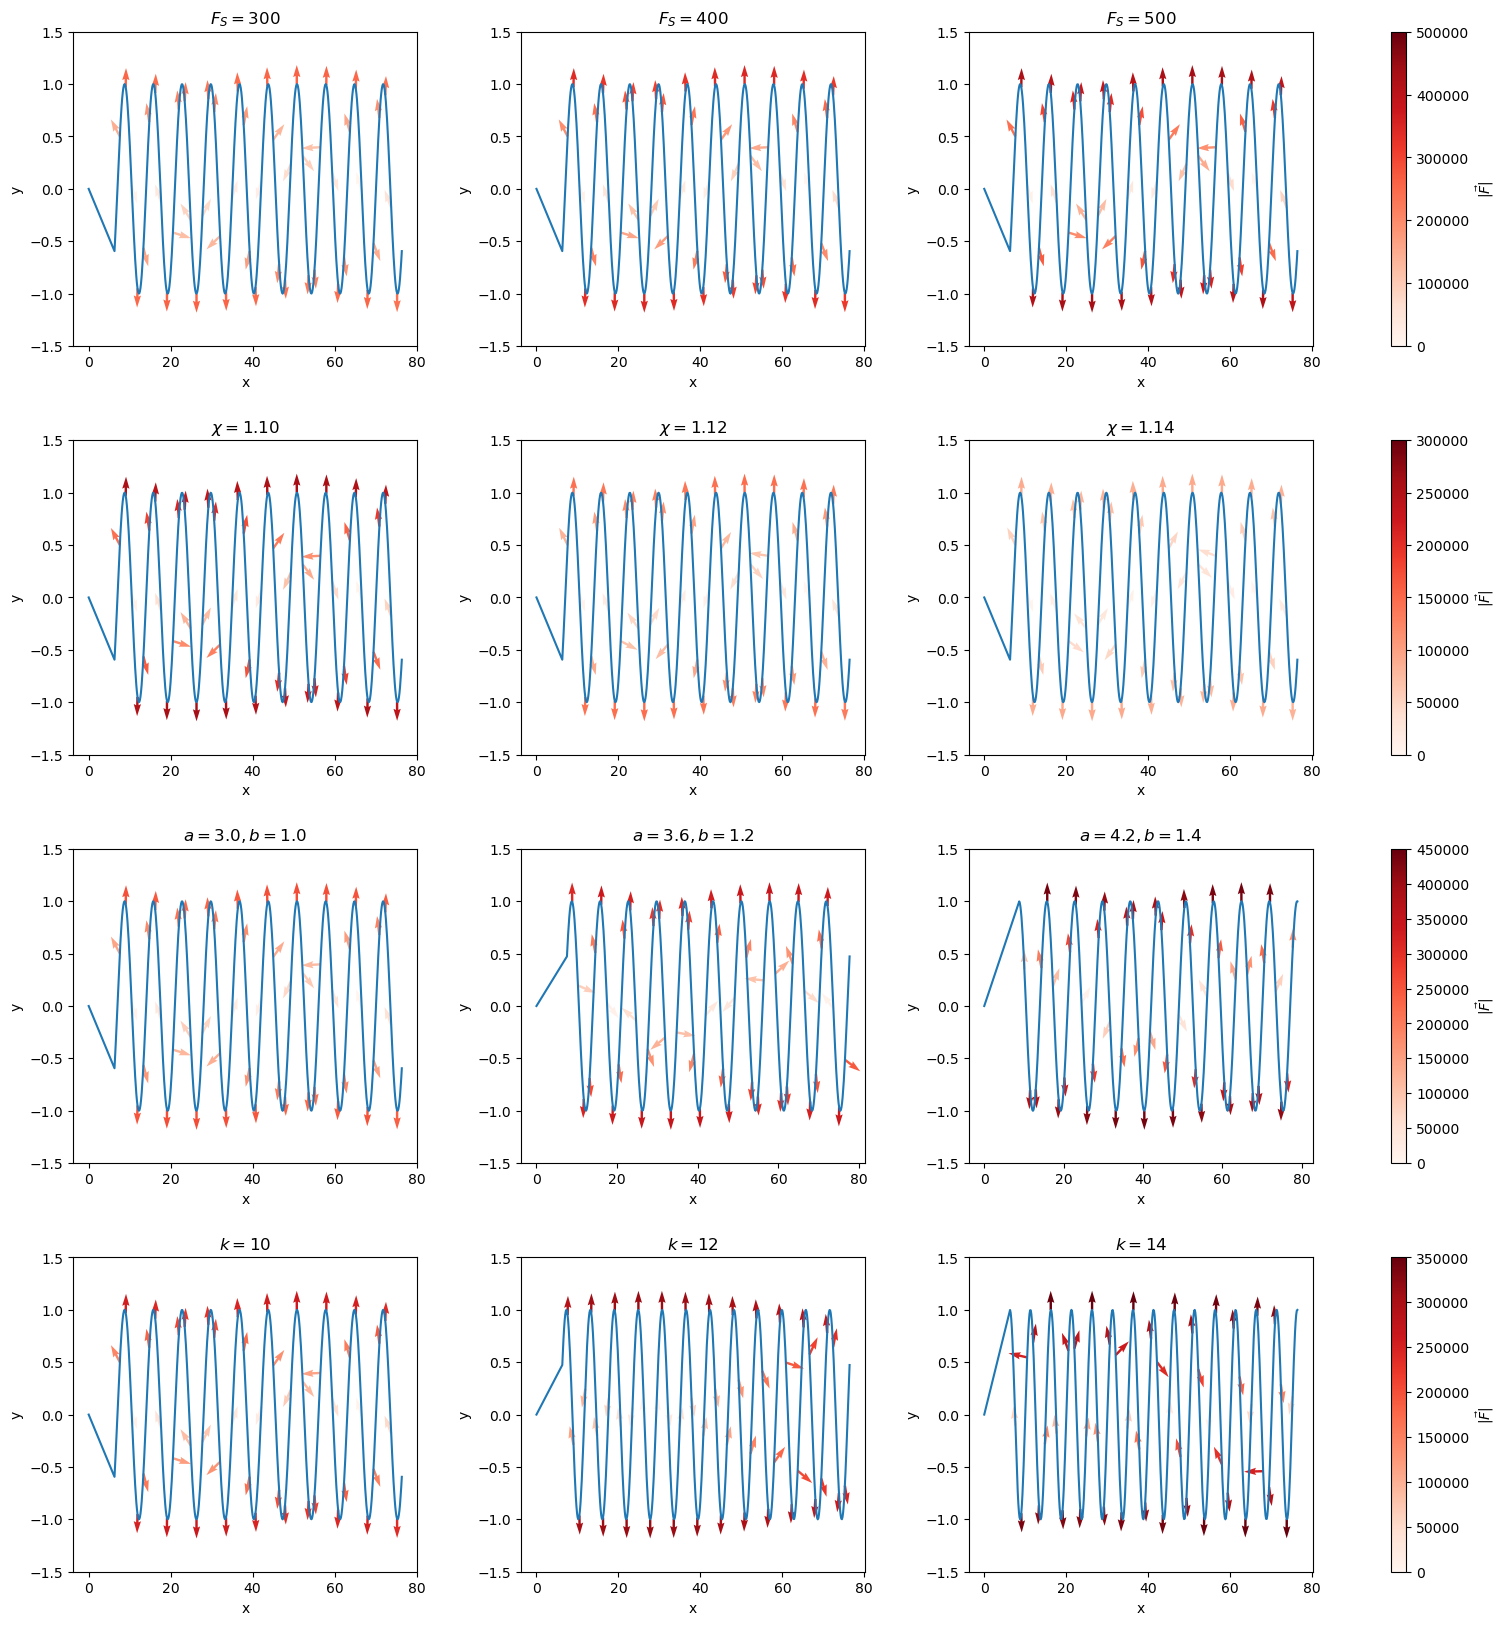

In [8]:
# force field plot. Check barrier_force method
fig, ax = plt.subplots(4, 3, figsize=(20, 20))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Different F_S
chi = 1.1
A = 1
k = 10
sperm = Sperm2D(n_segments=487)
x = np.hstack([0, np.arange(2.1*sperm.a, sperm.L+2.101*sperm.a, sperm.Delta_L)])
y = A*np.sin(2*np.pi*k*x/sperm.L)
s = np.vstack([x, y]).T
for i in range(3):
    F_S = 300+i*100
    F_B = barrier_force(s, sperm.a, sperm.b, F_S, chi)
    mag = np.sqrt(F_B[::10,0]**2+F_B[::10,1]**2)
    mask = mag > 0
    F_B_hat_x = F_B[::10,0][mask] / mag[mask]
    F_B_hat_y = F_B[::10,1][mask] / mag[mask]
    Q = ax[0, i].quiver(
    x[::10][mask], y[::10][mask],        # origins
    F_B_hat_x, F_B_hat_y,    # arrow components
    mag[mask],
    angles='xy',           # interpret u,v in data coords
    cmap='Reds',
    width=0.007,
    clim=(0, int(5e5)),
    )
    ax[0, i].plot(x, y)
    ax[0, i].set_ylim([-1.5, 1.5])
    ax[0, i].set_xlabel('x')
    ax[0, i].set_ylabel('y')
    ax[0, i].set_title(f'$F_S={F_S}$')
cbar = fig.colorbar(Q, ax=ax[0,:], label=r'$|\vec{F}|$')

# Different chi
F_S = 300
A = 1
k = 10
sperm = Sperm2D(n_segments=487)
x = np.hstack([0, np.arange(2.1*sperm.a, sperm.L+2.101*sperm.a, sperm.Delta_L)])
y = A*np.sin(2*np.pi*k*x/sperm.L)
s = np.vstack([x, y]).T
for i in range(3):
    chi = 1.1+i*0.02
    F_B = barrier_force(s, sperm.a, sperm.b, F_S, chi)
    mag = np.sqrt(F_B[::10,0]**2+F_B[::10,1]**2)
    mask = mag > 0
    F_B_hat_x = F_B[::10,0][mask] / mag[mask]
    F_B_hat_y = F_B[::10,1][mask] / mag[mask]
    Q = ax[1, i].quiver(
    x[::10][mask], y[::10][mask],        # origins
    F_B_hat_x, F_B_hat_y,    # arrow components
    mag[mask],
    angles='xy',           # interpret u,v in data coords
    cmap='Reds',
    width=0.007,
    clim=(0, int(3e5)),
    )
    ax[1, i].plot(x, y)
    ax[1, i].set_ylim([-1.5, 1.5])
    ax[1, i].set_xlabel('x')
    ax[1, i].set_ylabel('y')
    ax[1, i].set_title(f'$\\chi={chi:.2f}$')
cbar = fig.colorbar(Q, ax=ax[1,:], label=r'$|\vec{F}|$')

# Different a, b
F_S = 300
A = 1
k = 10
chi = 1.1
for i in range(3):
    sperm = Sperm2D(n_segments=487, head_semi_major=3+i*0.6, head_semi_minor=1+i*0.2)
    x = np.hstack([0, np.arange(2.1*sperm.a, sperm.L+2.101*sperm.a, sperm.Delta_L)])
    y = A*np.sin(2*np.pi*k*x/sperm.L)
    s = np.vstack([x, y]).T
    F_B = barrier_force(s, sperm.a, sperm.b, F_S, chi)
    mag = np.sqrt(F_B[::10,0]**2+F_B[::10,1]**2)
    mask = mag > 0
    F_B_hat_x = F_B[::10,0][mask] / mag[mask]
    F_B_hat_y = F_B[::10,1][mask] / mag[mask]
    Q = ax[2, i].quiver(
    x[::10][mask], y[::10][mask],        # origins
    F_B_hat_x, F_B_hat_y,    # arrow components
    mag[mask],
    angles='xy',           # interpret u,v in data coords
    cmap='Reds',
    width=0.007,
    clim=(0, int(4.5e5)),
    )
    ax[2, i].plot(x, y)
    ax[2, i].set_ylim([-1.5, 1.5])
    ax[2, i].set_xlabel('x')
    ax[2, i].set_ylabel('y')
    ax[2, i].set_title(f'$a={sperm.a:.1f}, b={sperm.b:.1f}$')
cbar = fig.colorbar(Q, ax=ax[2,:], label=r'$|\vec{F}|$')

# Different k
F_S = 300
A = 1
chi = 1.1
sperm = Sperm2D(n_segments=487, head_semi_major=3, head_semi_minor=1)
x = np.hstack([0, np.arange(2.1*sperm.a, sperm.L+2.101*sperm.a, sperm.Delta_L)])
for i in range(3):
    k = 10+i*2
    y = A*np.sin(2*np.pi*k*x/sperm.L)
    s = np.vstack([x, y]).T
    F_B = barrier_force(s, sperm.a, sperm.b, F_S, chi)
    mag = np.sqrt(F_B[::10,0]**2+F_B[::10,1]**2)
    mask = mag > 0
    F_B_hat_x = F_B[::10,0][mask] / mag[mask]
    F_B_hat_y = F_B[::10,1][mask] / mag[mask]
    Q = ax[3, i].quiver(
    x[::10][mask], y[::10][mask],        # origins
    F_B_hat_x, F_B_hat_y,    # arrow components
    mag[mask],
    angles='xy',           # interpret u,v in data coords
    cmap='Reds',
    width=0.007,
    clim=(0, int(3.5e5)),
    )
    ax[3, i].plot(x, y)
    ax[3, i].set_ylim([-1.5, 1.5])
    ax[3, i].set_xlabel('x')
    ax[3, i].set_ylabel('y')
    ax[3, i].set_title(f'$k={k}$')
cbar = fig.colorbar(Q, ax=ax[3,:], label=r'$|\vec{F}|$')

plt.show()

In [9]:
def elastic_torque(M):
    """
    Given bending moments at edges, M of length (N+2),
    returns elastic torques T_E on each of the N+1 segments.

    Parameters
    ----------
    M : ndarray, shape (N+2,)
        By free-end BCs, M[0] and M[N+1] should be zero.

    Returns
    -------
    T_E : ndarray, shape (N+1,)
        Elastic torques at the midpoint of each segment.
    """
    T_E = M[1:] - M[:-1]
    return T_E

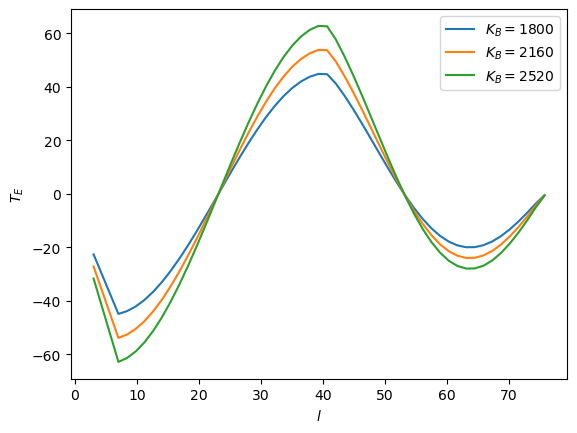

In [10]:
# T_E vs l graphs
# Different M
for i in range(3):
    bending_modulus = 1800+360*i
    sperm = Sperm2D(bending_modulus=bending_modulus)
    l = np.hstack([sperm.a, np.arange(2.1*sperm.a+sperm.Delta_L/2, sperm.L+2.1*sperm.a, sperm.Delta_L)])
    T_E = elastic_torque(sperm.internal_moment(0))
    plt.plot(l, T_E, label=f'$K_B={bending_modulus}$')
    plt.xlabel(r'$l$')
    plt.ylabel(r'$T_E$')
plt.legend()
plt.show()

In [11]:
def constraint_torque(Lambda, angles, a, Delta_L, n_segments):
    """
    Vectorized compute of constraint torques T_C on each segment midpoint.

    Parameters
    ----------
    Lambda : ndarray, shape (N+2, 2)
        Constraint forces at each segment edge, inclusive of head (0…N+1).
    angles : ndarray, shape (N+1,)
        Tangent angles at each segment midpoint, head inclusive (0…N).
    a, Delta_L: floats
        head and flagellum segment size, respectively.
    n_segments : int
        Number of flagellum segments, head exclusive (N).

    Returns
    -------
    T_C : ndarray, shape (N+1,)
        Scalar torque on each segment midpoint, head inclusive.
    """
    # Distance of each segment
    spacing = np.hstack([2*a, [Delta_L]*n_segments])

    # Sum adjacent Lambdas: shape (N+1, 2)
    lam_sum = Lambda[:-1] + Lambda[1:]

    # Tangent unit vector components: shape (N+1,)
    t_hat_x = np.cos(angles)
    t_hat_y = np.sin(angles)

    # Cross product t × lam_sum  in 2D: t_x*lam_y - t_y*lam_x
    torques = t_hat_x * lam_sum[:,1] - t_hat_y * lam_sum[:,0]

    T_C = 0.5 * spacing * torques
    return T_C

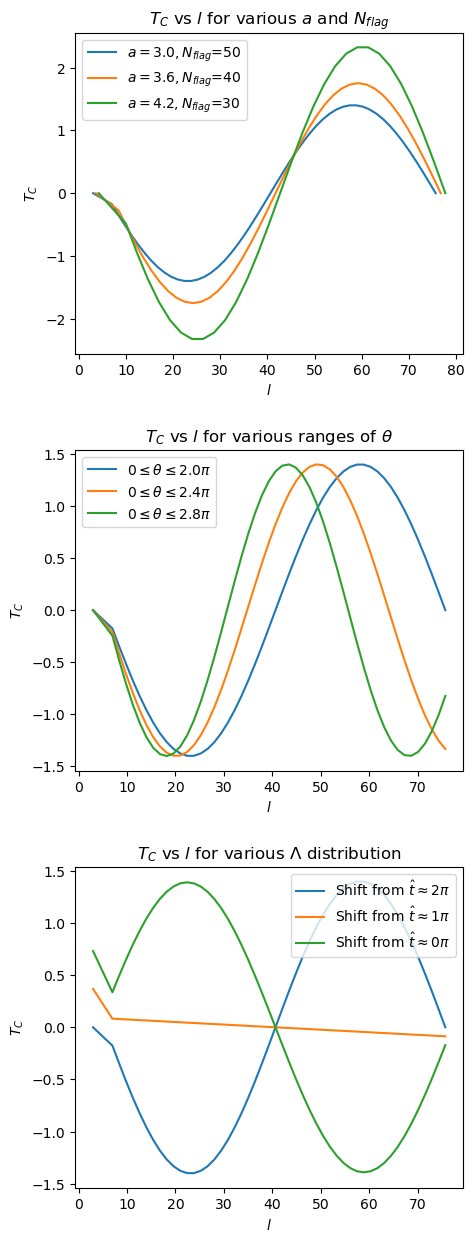

In [12]:
# M vs l graphs. Check internal_moment method
fig, ax = plt.subplots(3, 1, figsize=(5, 15))
plt.subplots_adjust(hspace=0.3)

# Different a and Delta_L
for i in range(3):
    head_semi_major = 3+i*0.6
    n_segments = 50 - i*10
    sperm = Sperm2D(n_segments=n_segments, head_semi_major=head_semi_major)
    l = np.hstack([sperm.a, np.arange(2.1*sperm.a+0.5*sperm.Delta_L, sperm.L+2.101*sperm.a, sperm.Delta_L)])
    Lambda = np.zeros((n_segments+2, 2))
    Lambda[:, 0] = 1
    angles = np.linspace(0, 2*np.pi, n_segments+1)
    T_C = constraint_torque(Lambda, angles, sperm.a, sperm.Delta_L, sperm.N_flag)
    ax[0].plot(l, T_C, label=f"$a={head_semi_major},$" + r'$N_{flag}$=' + f"${n_segments}$")
    ax[0].set_title(r'$T_C$ vs $l$ for various $a$ and $N_{flag}$')
    ax[0].set_xlabel(r'$l$')
    ax[0].set_ylabel(r'$T_C$')
    ax[0].legend()

# Different angles
for i in range(3):
    sperm = Sperm2D()
    l = np.hstack([sperm.a, np.arange(2.1*sperm.a+0.5*sperm.Delta_L, sperm.L+2.101*sperm.a, sperm.Delta_L)])
    Lambda = np.zeros((sperm.N_flag+2, 2))
    Lambda[:, 0] = 1
    angles = np.linspace(0, (2+i*0.4)*np.pi, sperm.N_flag+1)
    T_C = constraint_torque(Lambda, angles, sperm.a, sperm.Delta_L, sperm.N_flag)
    ax[1].plot(l, T_C, label=f"$0 \\leq \\theta \\leq {(2+i*0.4)}\\pi$")
    ax[1].set_title(r'$T_C$ vs $l$ for various ranges of $\theta$')
    ax[1].set_xlabel(r'$l$')
    ax[1].set_ylabel(r'$T_C$')
    ax[1].legend()

# Different Lambda
for i in range(3):
    sperm = Sperm2D()
    l = np.hstack([sperm.a, np.arange(2.1*sperm.a+0.5*sperm.Delta_L, sperm.L+2.101*sperm.a, sperm.Delta_L)])
    Lambda = np.zeros((sperm.N_flag+2, 2))
    gen_lamb = i*np.linspace(0, 2*np.pi, sperm.N_flag+2)
    Lambda[:, 0] = np.cos(gen_lamb)
    Lambda[:, 1] = np.sin(gen_lamb)
    angles = np.linspace(0, 2*np.pi, sperm.N_flag+1)
    T_C = constraint_torque(Lambda, angles, sperm.a, sperm.Delta_L, sperm.N_flag)
    ax[2].plot(l, T_C, label=r"Shift from $\hat{t}\approx$"+f"{2-i}"+r"$\pi$")
    ax[2].set_title(r'$T_C$ vs $l$ for various $\Lambda$ distribution')
    ax[2].set_xlabel(r'$l$')
    ax[2].set_ylabel(r'$T_C$')
    ax[2].legend()

plt.show()

In [14]:
def fcm_spread(F_B, Lambda, T_E, T_C, sperm_coordinates, L_x, L_y, N_x, N_y, sigma_Delta, sigma_Theta):
    """
    Calculate the spread of FCM force & torque onto a periodic 2D grid using convolution theorem.

    Parameters
    ----------
    F_B : array, shape (N+1, 2)
        Barrier force acting at the midpoint of each segment.
    Lambda : array, shape (N+2, 2)
        Constraint force acting at the edge of each segment.
    T_E, T_C : array, shape (N+1)
        Elastic and constraint torques acting at the midpoint of each segment.
    sperm_coordinates : array, shape (2N+3, 2)
        Positions of the edges and midpoint of each segment. Already corrected for periodic boundary conditions.
    L_x, L_y : floats
        Dimensions of the simulation domain
    N_x, N_y : integers
        Number of grids in each axis
    sigma_Delta, sigma_Theta: floats
        Gaussian envelope sizes for force and torque respectively.

    Returns
    -------
    f : array, shape (N_x, N_y, 2)
        The x and y-components of the force and torque field after Gaussian spread.
    """
    N_s = len(F_B)
    F_complex = np.zeros((N_x, N_y), dtype=complex)
    T_z = np.zeros((N_x, N_y))
    F_total = np.zeros((2*N_s+1, 2))
    F_total[0::2] = Lambda # edges
    F_total[1::2] = F_B # midpoints
    T_total = T_E + T_C
    dx = L_x/(N_x-1)
    dy = L_y/(N_y-1)
    idxD = np.round((sperm_coordinates[:,0]+L_x/2)/dx).astype(int)
    idyD = np.round((sperm_coordinates[:,1]+L_y/2)//dy).astype(int)
    np.add.at(F_complex.real, (idxD,idyD), F_total[:,0])
    np.add.at(F_complex.imag, (idxD,idyD), F_total[:,1])
    kD = int(6 * sigma_Delta / dx)  # cover 3*sigma
    if kD % 2 == 0:
        kD += 1
    gridD = np.linspace(-3*sigma_Delta, 3*sigma_Delta, kD)
    GXD, GYD = np.meshgrid(gridD, gridD, indexing='ij')
    GD = np.exp(-(GXD**2 + GYD**2) / (2*sigma_Delta**2)) / (2*np.pi*sigma_Delta**2)
    f_complex = oaconvolve(F_complex, GD, mode='same')
    idxT = idxD[1::2]
    idyT = idyD[1::2]
    np.add.at(T_z, (idxT,idyT), T_total)
    kT = int(6 * sigma_Theta / dx)  # cover 3*sigma
    if kT % 2 == 0:
        kT += 1
    gridT = np.linspace(-3*sigma_Theta, 3*sigma_Theta, kT)
    GXT, GYT = np.meshgrid(gridT, gridT, indexing='ij')
    GT = np.exp(-(GXT**2 + GYT**2) / (2*sigma_Theta**2)) / (2*np.pi*sigma_Theta**2)
    gx = -GXT * GT / sigma_Theta**2
    gy = -GYT * GT / sigma_Theta**2
    g_complex = gy -1j*gx
    f_complex += 0.5*oaconvolve(T_z, g_complex, mode='same')
    f = np.stack((f_complex.real, f_complex.imag), axis=-1)
    return f

In [78]:
def fcm_spread(
    F_B, Lambda, T_E, T_C, coords,
    L_x, L_y, N_x, N_y, sigma_D, sigma_T
):
    """
    Calculate the spread of FCM force & torque onto a periodic 2D grid using convolution theorem.

    Parameters
    ----------
    F_B : array, shape (N+1, 2)
        Barrier force acting at the midpoint of each segment.
    Lambda : array, shape (N+2, 2)
        Constraint force acting at the edge of each segment.
    T_E, T_C : array, shape (N+1)
        Elastic and constraint torques acting at the midpoint of each segment.
    coords : array, shape (2N+3, 2)
        Positions of the edges and midpoint of each segment.
    L_x, L_y : floats
        Dimensions of the simulation domain
    N_x, N_y : integers
        Number of grids in each axis
    sigma_D, sigma_T: floats
        Gaussian envelope sizes for force and torque respectively.

    Returns
    -------
    f : cupy.ndarray, shape (N_x, N_y, 2)
        The x and y-components of the force and torque field after Gaussian spread.
    """
    F_B = cp.asarray(F_B)
    Lambda = cp.asarray(Lambda)
    T_E = cp.asarray(T_E)
    T_C = cp.asarray(T_C)
    coords = cp.asarray(coords)
    
    # 1) Build & cache kernel FFTs on GPU
    cache_key = (N_x, N_y, L_x, L_y, sigma_D, sigma_T)
    if not hasattr(fcm_spread, "_gpu_cache"):
        fcm_spread._gpu_cache = {}
    if cache_key not in fcm_spread._gpu_cache:
        # Build full‐grid coordinates in real‐space (centered)
        x = cp.linspace(-0.5*L_x, 0.5*L_x, N_x, endpoint=False)
        y = cp.linspace(-0.5*L_y, 0.5*L_y, N_y, endpoint=False)
        X, Y = cp.meshgrid(x, y, indexing='ij')  # (N_x,N_y)
    
        # Delta‐kernel
        GD = cp.exp(-(X*X + Y*Y)/(2*sigma_D**2), dtype=cp.float64)
        GD /= (2*cp.pi * sigma_D**2)
        Ghat_D = cp.fft.fft2(GD)
    
        # g_complex = gy - i gx  for Θ derivative
        GT = cp.exp(-(X*X + Y*Y)/(2*sigma_T**2), dtype=cp.float64)
        GT /= (2*cp.pi * sigma_T**2)
        gx = -X * GT / (sigma_T**2)
        gy = -Y * GT / (sigma_T**2)
        g_complex = gy.astype(cp.complex128) + (-1j * gx.astype(cp.complex128))
        Ghat_T = cp.fft.fft2(g_complex)
    
        fcm_spread._gpu_cache[cache_key] = (Ghat_D, Ghat_T)

    Ghat_D, Ghat_T = fcm_spread._gpu_cache[cache_key]
            
    # 2) Scatter forces & torques onto a complex grid
    dx = L_x / N_x
    dy = L_y / N_y

    # grid‐indices for each coordinate (nearest‐round, periodic)
    idx = cp.mod(cp.rint((coords[:,0] + 0.5*L_x) / dx).astype(int), N_x)
    idy = cp.mod(cp.rint((coords[:,1] + 0.5*L_y) / dy).astype(int), N_y)

    # allocate force‐grid
    Fc = cp.zeros((N_x, N_y), dtype=cp.complex128)

    # edges (even slots of coords) = Lambda, midpoints (odd) = F_B
    N_s = len(F_B)
    F_total = cp.zeros((2*N_s+1, 2))
    F_total[0::2] = Lambda # edges
    F_total[1::2] = F_B # midpoints
    
    # scatter real/imag 
    scatter_add(Fc.real, (idx, idy), F_total[:, 0])
    scatter_add(Fc.imag, (idx, idy), F_total[:, 1])
    

    # torque‐grid
    Tz = cp.zeros((N_x, N_y), dtype=cp.float64)
    scatter_add(Tz, (idx[1::2], idy[1::2]), T_E+T_C)

    # 3) FFT both
    Fhat = cp.fft.fft2(Fc)
    That = cp.fft.fft2(Tz)

    # 4) Convolve in Fourier-space
    conv_F = cp.fft.ifft2(Fhat * Ghat_D)
    conv_T = cp.fft.ifft2(That * Ghat_T)

    # 5) Combine & return (complex → 2-component real)
    f_complex = conv_F + 0.5 * conv_T
    f = cp.stack((f_complex.real, f_complex.imag), axis=-1)
    return f

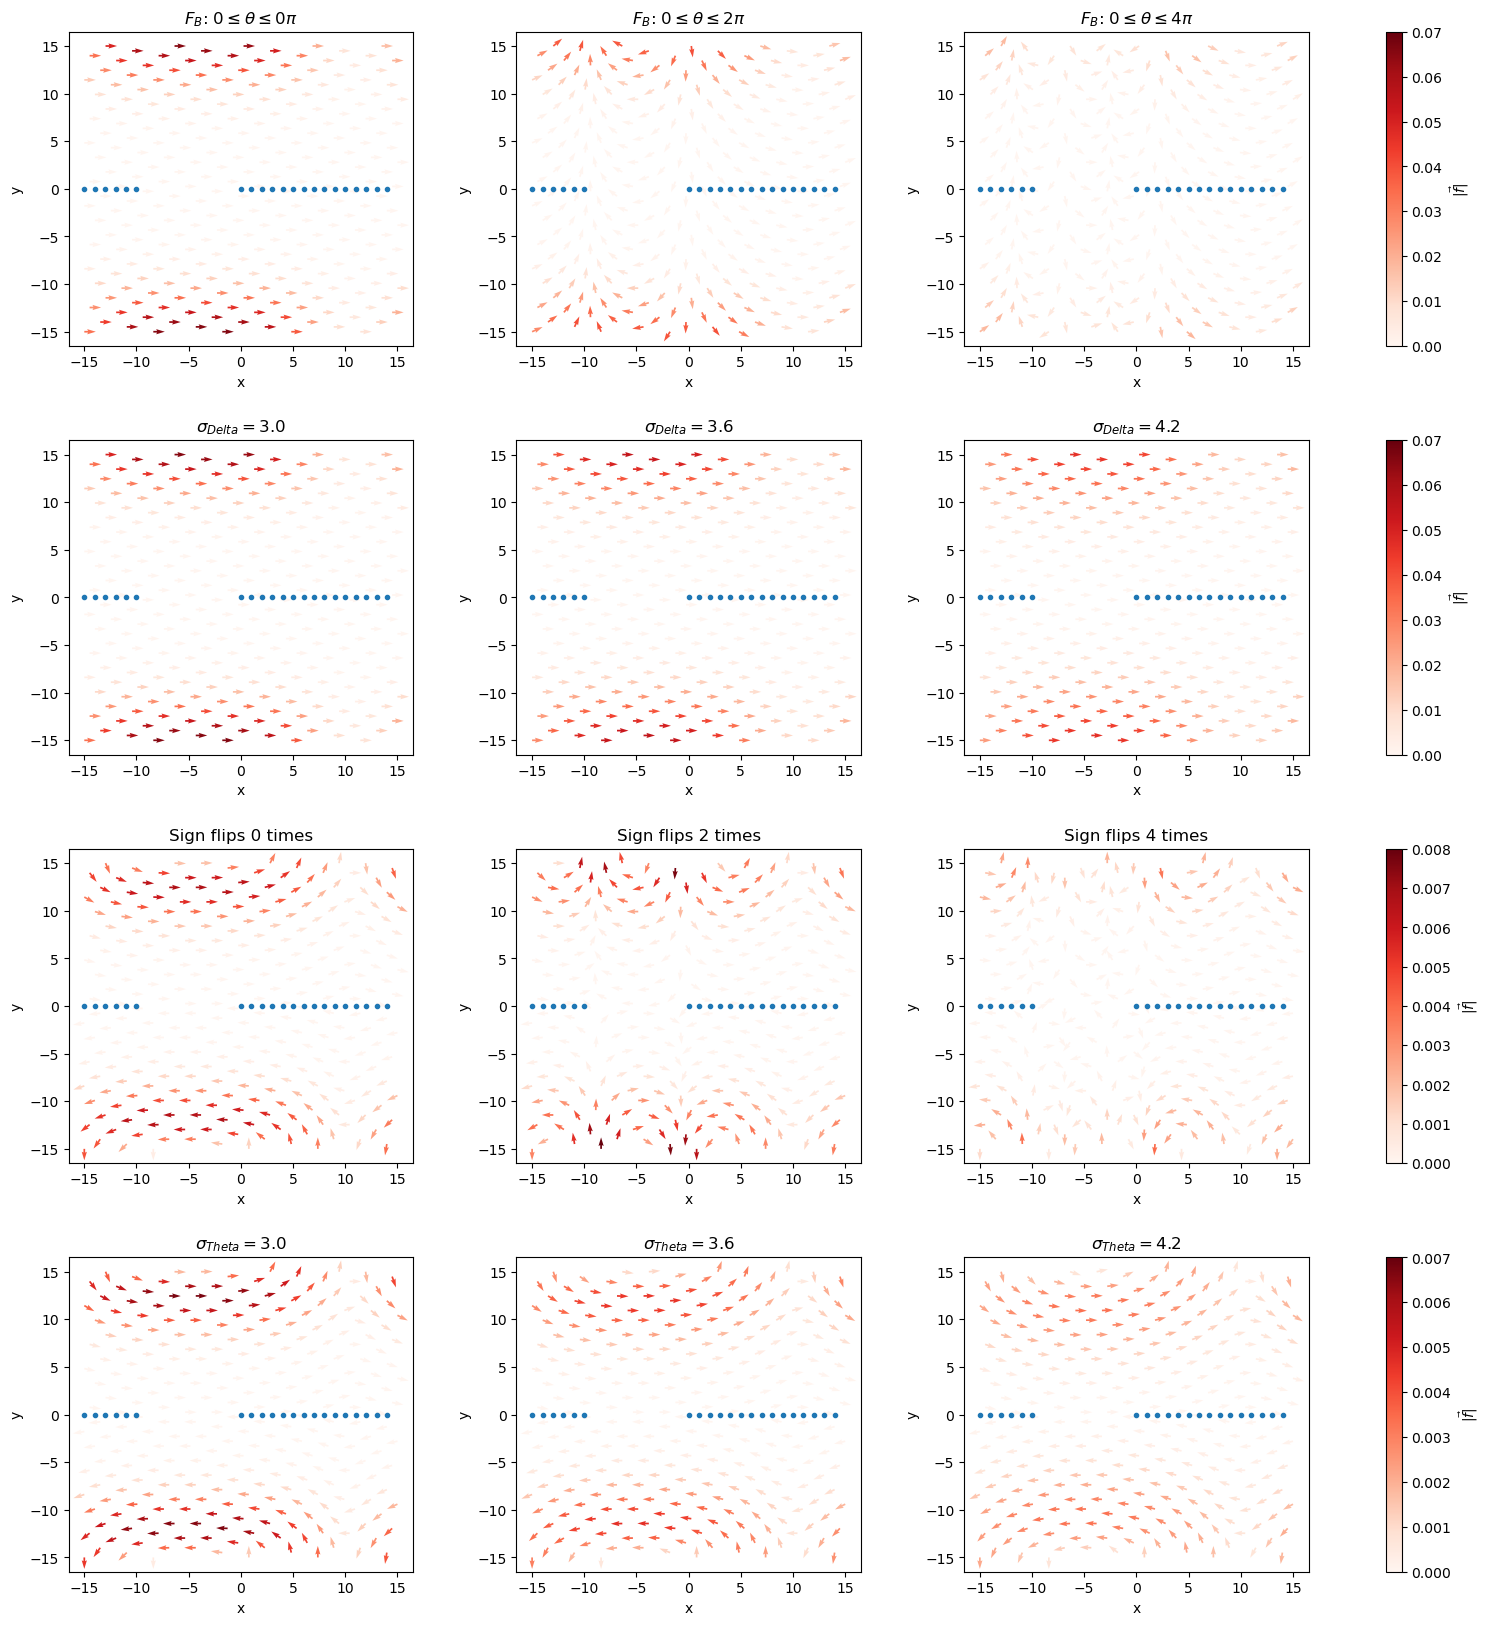

In [79]:
# Check fcm_spread function
fig, ax = plt.subplots(4, 3, figsize=(20, 20))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
quiver_step = 13
mag_threshold = 1e-8

# Different F_B
Lambda = np.zeros((11, 2))
T_E = T_C = np.zeros(10)
x = np.linspace(0, 20, 21)
y = np.zeros(21)
L_x = L_y = 30
N_x = N_y = 60
x[x >= L_x*0.5] -= L_x
x[x < -L_x*0.5] += L_x
y[y >= L_y*0.5] -= L_y
y[y < -L_y*0.5] += L_y
s = np.vstack([x, y]).T
sigma_Delta = sigma_Theta = 3
for i in range(3):
    F_B = np.zeros((10, 2))
    gen_f = i*np.linspace(0, 2*np.pi, 10)
    F_B[:, 0] = np.cos(gen_f)
    F_B[:, 1] = np.sin(gen_f)
    f = cp.asnumpy(fcm_spread(F_B, Lambda, T_E, T_C, s, L_x, L_y, N_x, N_y, sigma_Delta, sigma_Theta))
    grid_x = np.linspace(-0.5*L_x, 0.5*L_x, N_x)
    grid_y = np.linspace(-0.5*L_y, 0.5*L_y, N_y)
    grid_x, grid_y = np.meshgrid(grid_x, grid_y, indexing='ij')
    mag = np.sqrt(f[...,0]**2+f[...,1]**2)
    mask = mag > mag_threshold
    f_hat_x = f[...,0][mask] / mag[mask]
    f_hat_y = f[...,1][mask] / mag[mask]
    Q = ax[0, i].quiver(
    grid_x[mask][::quiver_step], grid_y[mask][::quiver_step],        # origins
    f_hat_x[::quiver_step], f_hat_y[::quiver_step],    # arrow components
    mag[mask][::quiver_step],
    angles='xy',           # interpret u,v in data coords
    cmap='Reds',
    width=0.005,
    clim=(0, 0.07),
    )
    ax[0, i].plot(x, y, '.')
    ax[0, i].set_title(r"$F_B$:"+f" $0 \\leq \\theta \\leq {(2*i)}\\pi$")
    ax[0, i].set_xlabel('x')
    ax[0, i].set_ylabel('y')
plt.colorbar(Q, ax=ax[0, :], label=r'$|\vec{f}|$')

# Different sigma_Delta
Lambda = np.zeros((11, 2))
T_E = T_C = np.zeros(10)
x = np.linspace(0, 20, 21)
y = np.zeros(21)
L_x = L_y = 30
N_x = N_y = 60
x[x >= L_x*0.5] -= L_x
x[x < -L_x*0.5] += L_x
y[y >= L_y*0.5] -= L_y
y[y < -L_y*0.5] += L_y
s = np.vstack([x, y]).T
sigma_Theta = 3
F_B = np.zeros((10, 2))
F_B[:, 0] = 1
for i in range(3):
    sigma_Delta = 3 + i*0.6
    f = cp.asnumpy(fcm_spread(F_B, Lambda, T_E, T_C, s, L_x, L_y, N_x, N_y, sigma_Delta, sigma_Theta))
    grid_x = np.linspace(-0.5*L_x, 0.5*L_x, N_x)
    grid_y = np.linspace(-0.5*L_y, 0.5*L_y, N_y)
    grid_x, grid_y = np.meshgrid(grid_x, grid_y, indexing='ij')
    mag = np.sqrt(f[...,0]**2+f[...,1]**2)
    mask = mag > mag_threshold
    f_hat_x = f[...,0][mask] / mag[mask]
    f_hat_y = f[...,1][mask] / mag[mask]
    Q = ax[1, i].quiver(
    grid_x[mask][::quiver_step], grid_y[mask][::quiver_step],        # origins
    f_hat_x[::quiver_step], f_hat_y[::quiver_step],    # arrow components
    mag[mask][::quiver_step],
    angles='xy',           # interpret u,v in data coords
    cmap='Reds',
    width=0.005,
    clim=(0, 0.07),
    )
    ax[1, i].plot(x, y, '.')
    ax[1, i].set_title(r"$\sigma_{Delta}=$"+f"{sigma_Delta:.1f}")
    ax[1, i].set_xlabel('x')
    ax[1, i].set_ylabel('y')
fig.colorbar(Q, ax=ax[1, :], label=r'$|\vec{f}|$')

# Different T_E
Lambda = np.zeros((11, 2))
T_C = np.zeros(10)
x = np.linspace(0, 20, 21)
y = np.zeros(21)
L_x = L_y = 30
N_x = N_y = 60
x[x >= L_x*0.5] -= L_x
x[x < -L_x*0.5] += L_x
y[y >= L_y*0.5] -= L_y
y[y < -L_y*0.5] += L_y
s = np.vstack([x, y]).T
sigma_Delta = sigma_Theta = 3
F_B = np.zeros((10, 2))
for i in range(3):
    gen_t = i*np.linspace(0, 2*np.pi, 10)
    T_E = np.sign(np.cos(gen_t))
    f = cp.asnumpy(fcm_spread(F_B, Lambda, T_E, T_C, s, L_x, L_y, N_x, N_y, sigma_Delta, sigma_Theta))
    grid_x = np.linspace(-0.5*L_x, 0.5*L_x, N_x)
    grid_y = np.linspace(-0.5*L_y, 0.5*L_y, N_y)
    grid_x, grid_y = np.meshgrid(grid_x, grid_y, indexing='ij')
    mag = np.sqrt(f[...,0]**2+f[...,1]**2)
    mask = mag > mag_threshold
    f_hat_x = f[...,0][mask] / mag[mask]
    f_hat_y = f[...,1][mask] / mag[mask]
    Q = ax[2, i].quiver(
    grid_x[mask][::quiver_step], grid_y[mask][::quiver_step],        # origins
    f_hat_x[::quiver_step], f_hat_y[::quiver_step],    # arrow components
    mag[mask][::quiver_step],
    angles='xy',           # interpret u,v in data coords
    cmap='Reds',
    width=0.005,
    clim=(0, 0.008)
    )
    ax[2, i].plot(x, y, '.')
    ax[2, i].set_title(f"Sign flips {2*i} times")
    ax[2, i].set_xlabel('x')
    ax[2, i].set_ylabel('y')
fig.colorbar(Q, ax=ax[2, :], label=r'$|\vec{f}|$')

# Different sigma_Theta
Lambda = np.zeros((11, 2))
T_C = np.zeros(10)
x = np.linspace(0, 20, 21)
y = np.zeros(21)
L_x = L_y = 30
N_x = N_y = 60
x[x >= L_x*0.5] -= L_x
x[x < -L_x*0.5] += L_x
y[y >= L_y*0.5] -= L_y
y[y < -L_y*0.5] += L_y
s = np.vstack([x, y]).T
sigma_Delta = 3
F_B = np.zeros((10, 2))
T_E = np.ones(10)
for i in range(3):
    sigma_Theta = 3 + i*0.6
    f = cp.asnumpy(fcm_spread(F_B, Lambda, T_E, T_C, s, L_x, L_y, N_x, N_y, sigma_Delta, sigma_Theta))
    grid_x = np.linspace(-0.5*L_x, 0.5*L_x, N_x)
    grid_y = np.linspace(-0.5*L_y, 0.5*L_y, N_y)
    grid_x, grid_y = np.meshgrid(grid_x, grid_y, indexing='ij')
    mag = np.sqrt(f[...,0]**2+f[...,1]**2)
    mask = mag > mag_threshold
    f_hat_x = f[...,0][mask] / mag[mask]
    f_hat_y = f[...,1][mask] / mag[mask]
    Q = ax[3, i].quiver(
    grid_x[mask][::quiver_step], grid_y[mask][::quiver_step],        # origins
    f_hat_x[::quiver_step], f_hat_y[::quiver_step],    # arrow components
    mag[mask][::quiver_step],
    angles='xy',           # interpret u,v in data coords
    cmap='Reds',
    width=0.005,
    clim=(0, 0.007)
    )
    ax[3, i].plot(x, y, '.')
    ax[3, i].set_title(r"$\sigma_{Theta}=$"+f"{sigma_Theta:.1f}")
    ax[3, i].set_xlabel('x')
    ax[3, i].set_ylabel('y')
fig.colorbar(Q, ax=ax[3, :], label=r'$|\vec{f}|$')

plt.show()

In [35]:
def solve_stokes(f_gpu, L_x, L_y, eta):
    """
    GPU‐accelerated Stokes solver via FCM/FFT on a periodic 2D box.

    Parameters
    ----------
    f_gpu : cupy.ndarray, shape (N_x, N_y, 2)
        The (x,y) force‐density on the uniform grid.
    L_x, L_y : floats
        Domain sizes in x and y (periodic box).
    eta : float
        Viscosity of the fluid.

    Returns
    -------
    u_x, u_y : numpy.ndarray
        The real‐space velocity on the same (N_x x N_y) grid, returned to CPU.
    """
    # 1) Split x- amd y-components
    f_x_gpu = f_gpu[..., 0]
    f_y_gpu = f_gpu[..., 1]

    # 2) Grid dimensions
    N_x, N_y = f_x_gpu.shape

    # 3) Build/cache  k_x, k_y, and inv_k2 on GPU.  Keyed on (N_x,N_y,L_x,L_y).
    #    We attach them to the function object as solve_stokes._gpu_cache
    cache_key = (N_x, N_y, L_x, L_y)
    if not hasattr(solve_stokes, "_gpu_cache"):
        solve_stokes._gpu_cache = {}
    if cache_key not in solve_stokes._gpu_cache:
        # 3a) Build 1D frequency vectors (on CPU), then move to GPU
        #     np.fft.fftfreq(N) returns [0,  1/N,  2/N, …,  -(1/N), …]
        kx_1d_gpu = (2 * cp.pi * N_x / L_x) * cp.fft.fftfreq(N_x)  # length N_x on CPU
        ky_1d_gpu = (2 * cp.pi * N_y / L_y) * cp.fft.fftfreq(N_y)  # length N_y on CPU

        # 3b) Make 2D mesh of k_x, k_y on GPU
        k_x_gpu, k_y_gpu = cp.meshgrid(kx_1d_gpu, ky_1d_gpu, indexing='ij')  # shape (N_x, N_y)

        # 3c) Compute squared magnitude and its reciprocal (inv_k2)
        k2_gpu = (k_x_gpu**2 + k_y_gpu**2).astype(cp.float64)
        inv_k2_gpu = cp.zeros_like(k2_gpu)
        nonzero = k2_gpu > 1e-16
        inv_k2_gpu[nonzero] = 1.0 / k2_gpu[nonzero]

        # 3d) Cache them
        solve_stokes._gpu_cache[cache_key] = (k_x_gpu, k_y_gpu, inv_k2_gpu)

    # 4) Retrieve from cache
    k_x_gpu, k_y_gpu, inv_k2_gpu = solve_stokes._gpu_cache[cache_key]

    # 5) Forward FFT of the two force components (on GPU)
    fhat_x = cp.fft.fft2(f_x_gpu)
    fhat_y = cp.fft.fft2(f_y_gpu)

    # 6) Compute k·\hat{k} in Fourier space:
    #    shape (N_x, N_y), complex
    k_dot_fhat = (k_x_gpu * fhat_x) + (k_y_gpu * fhat_y)

    # 7) Build \hat{u}_x, \hat{u}_y via projection and division by (eta |k|^2):
    #    \hat{u}_x = [ fhat_x − k_x (k·\hat{f})/|k|^2 ] / (eta |k|^2),
    #    \hat{u}_y = [ fhat_y − k_y (k·\hat{f})/|k|^2 ] / (eta |k|^2).
    #
    #    Because inv_k2_gpu[0,0] = 0, the (0,0) mode is automatically set to zero.
    factor = inv_k2_gpu / eta             # (N_x, N_y) real
    temp = k_dot_fhat * inv_k2_gpu        # (k·\hat{f})/|k|^2, zero at (0,0)
    uhat_x = (fhat_x - k_x_gpu * temp) * factor
    uhat_y = (fhat_y - k_y_gpu * temp) * factor

    # 8) Inverse FFT → real space (on GPU), then drop any tiny imaginary bits
    u_x_gpu = cp.real(cp.fft.ifft2(uhat_x))
    u_y_gpu = cp.real(cp.fft.ifft2(uhat_y))

    # 9) Copy results back to CPU as NumPy arrays
    u_x = cp.asnumpy(u_x_gpu)
    u_y = cp.asnumpy(u_y_gpu)

    return u_x, u_y

In [36]:
eta = 1
L_x = L_y =1000
x = np.linspace(-L_x/2, L_x/2, 3000)
y = np.linspace(-L_y/2, L_y/2, 3000)
grid_x, grid_y = np.meshgrid(x, y, indexing='ij')
f = np.zeros((3000, 3000, 2))
f[..., 1] = np.sin(2*np.pi*grid_x/L_x)

In [37]:
%%timeit
solve_stokes(f, L_x, L_y, eta)

125 ms ± 1.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


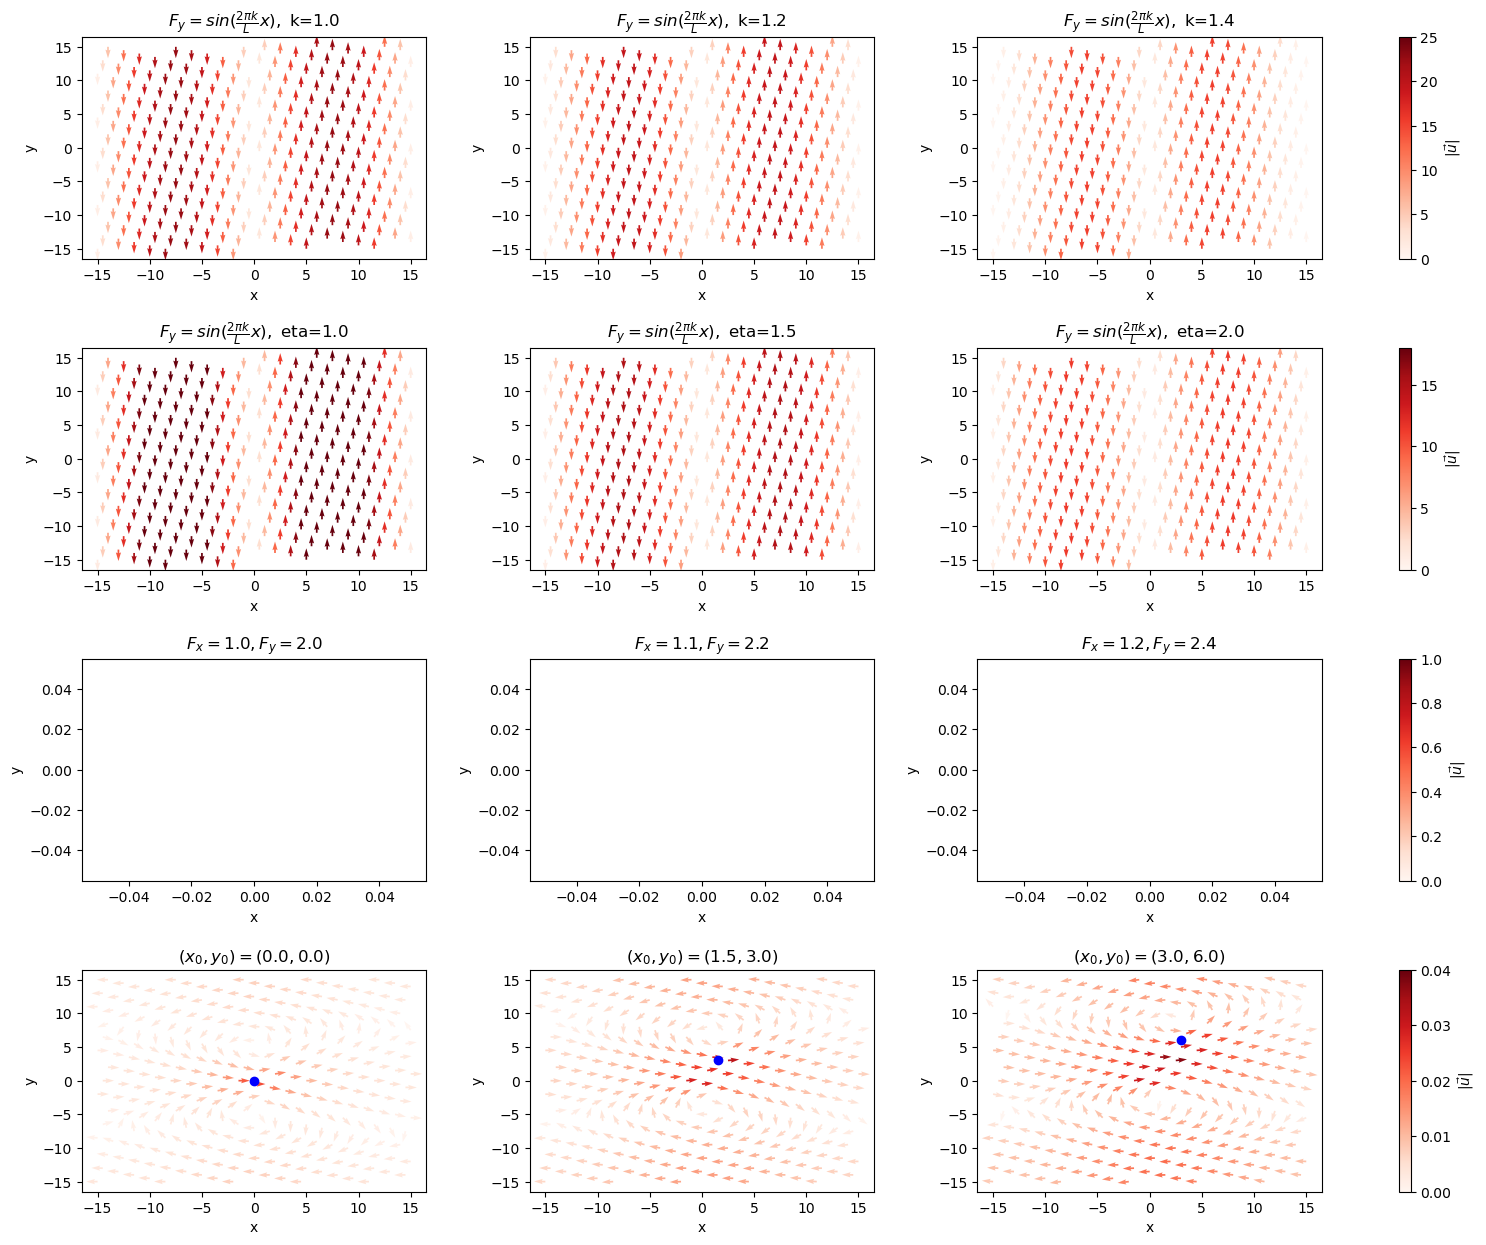

In [38]:
# Check solve_stokes function
fig, ax = plt.subplots(4, 3, figsize=(20, 15))
plt.subplots_adjust(wspace=0.3, hspace=0.4)
quiver_step = 13
mag_threshold = 1e-7

# Sinusoidal force with varying k_x, constant eta
eta = 1
L_x = L_y = 30
x = np.linspace(-L_x/2, L_x/2, 61)
y = np.linspace(-L_y/2, L_y/2, 61)
grid_x, grid_y = np.meshgrid(x, y, indexing='ij')
f = np.zeros((61, 61, 2))
for i in range(3):
    f[..., 1] = np.sin(2*np.pi*(1+0.2*i)*grid_x/L_x)
    u_x, u_y = solve_stokes(f, L_x, L_y, eta)
    mag = np.sqrt(u_x**2+u_y**2)
    mask = mag > mag_threshold
    u_hat_x = u_x[mask] / mag[mask]
    u_hat_y = u_y[mask] / mag[mask]
    Q = ax[0, i].quiver(
    grid_x[mask][::quiver_step], grid_y[mask][::quiver_step],        # origins
    u_hat_x[::quiver_step], u_hat_y[::quiver_step],    # arrow components
    mag[mask][::quiver_step],
    angles='xy',           # interpret u,v in data coords
    cmap='Reds',
    width=0.005,
    clim=(0, 25),
    )
    ax[0, i].set_title(r"$F_y = sin (\frac{2 \pi k}{L}x), $"+f" k={1+0.2*i:.1f}")
    ax[0, i].set_xlabel('x')
    ax[0, i].set_ylabel('y')
plt.colorbar(Q, ax=ax[0, :], label=r'$|\vec{u}|$')

# Sinusoidal force with constant k_x, varying eta
L_x = L_y = 30
x = np.linspace(-L_x/2, L_x/2, 61)
y = np.linspace(-L_y/2, L_y/2, 61)
grid_x, grid_y = np.meshgrid(x, y, indexing='ij')
f = np.zeros((61, 61, 2))
f[..., 1] = np.sin(2*np.pi*(1)*grid_x/L_x)
for i in range(3):
    eta = 1 + 0.5*i
    u_x, u_y = solve_stokes(f, L_x, L_y, eta)
    mag = np.sqrt(u_x**2+u_y**2)
    mask = mag > mag_threshold
    u_hat_x = u_x[mask] / mag[mask]
    u_hat_y = u_y[mask] / mag[mask]
    Q = ax[1, i].quiver(
    grid_x[mask][::quiver_step], grid_y[mask][::quiver_step],        # origins
    u_hat_x[::quiver_step], u_hat_y[::quiver_step],    # arrow components
    mag[mask][::quiver_step],
    angles='xy',           # interpret u,v in data coords
    cmap='Reds',
    width=0.005,
    clim=(0, 18),
    )
    ax[1, i].set_title(r"$F_y = sin (\frac{2 \pi k}{L}x), $"+f" eta={eta}")
    ax[1, i].set_xlabel('x')
    ax[1, i].set_ylabel('y')
plt.colorbar(Q, ax=ax[1, :], label=r'$|\vec{u}|$')

# Constant force of increasing magnitude
L_x = L_y = 30
x = np.linspace(-L_x/2, L_x/2, 61)
y = np.linspace(-L_y/2, L_y/2, 61)
grid_x, grid_y = np.meshgrid(x, y, indexing='ij')
f = np.zeros((61, 61, 2))
for i in range(3):
    fx = 1+0.1*i
    fy = 2+0.2*i
    f[..., 0] = fx
    f[..., 1] = fy
    u_x, u_y = solve_stokes(f, L_x, L_y, eta)
    mag = np.sqrt(u_x**2+u_y**2)
    mask = mag > mag_threshold
    u_hat_x = u_x[mask] / mag[mask]
    u_hat_y = u_y[mask] / mag[mask]
    Q = ax[2, i].quiver(
    grid_x[mask][::quiver_step], grid_y[mask][::quiver_step],        # origins
    u_hat_x[::quiver_step], u_hat_y[::quiver_step],    # arrow components
    mag[mask][::quiver_step],
    angles='xy',           # interpret u,v in data coords
    cmap='Reds',
    width=0.005,
    clim=(0, 1),
    )
    ax[2, i].set_title(f"$F_x={fx}, F_y={fy}$")
    ax[2, i].set_xlabel('x')
    ax[2, i].set_ylabel('y')
plt.colorbar(Q, ax=ax[2, :], label=r'$|\vec{u}|$')

# Point force at different source points
L_x = L_y = 30
x = np.linspace(-L_x/2, L_x/2, 61)
y = np.linspace(-L_y/2, L_y/2, 61)
grid_x, grid_y = np.meshgrid(x, y, indexing='ij')
f = np.zeros((61, 61, 2))
for i in range(3):
    x_pos = 30+3*i
    y_pos = 30+6*i
    f[x_pos, y_pos, 0] = 1
    u_x, u_y = solve_stokes(f, L_x, L_y, eta)
    mag = np.sqrt(u_x**2+u_y**2)
    mask = mag > mag_threshold
    u_hat_x = u_x[mask] / mag[mask]
    u_hat_y = u_y[mask] / mag[mask]
    Q = ax[3, i].quiver(
    grid_x[mask][::quiver_step], grid_y[mask][::quiver_step],        # origins
    u_hat_x[::quiver_step], u_hat_y[::quiver_step],    # arrow components
    mag[mask][::quiver_step],
    angles='xy',           # interpret u,v in data coords
    cmap='Reds',
    width=0.005,
    clim=(0, 0.04),
    )
    ax[3, i].set_title(f"$(x_0, y_0) = ({x[x_pos]}, {y[y_pos]})$")
    ax[3, i].set_xlabel('x')
    ax[3, i].set_ylabel('y')
    ax[3, i].plot(x[x_pos], y[y_pos], 'bo')
plt.colorbar(Q, ax=ax[3, :], label=r'$|\vec{u}|$')

plt.show()

In [39]:
def segment_velocities(
    u_x, u_y, L_x, L_y, segment_positions, a, b, sigma_D, sigma_T
):
    """
    Compute linear and angular velocities of each filament segment from a 2D fluid velocity field,
    using convolution with Gaussian kernels Delta and Theta.

    Parameters
    ----------
    u_x, u_y : numpy.ndarrays, shape (N_x, N_y)
        The fluid velocity components on a uniform, periodic 2D grid.
    L_x, L_y : floats
        Domain sizes in x and y (periodic box). 
    segment_positions : numpy.ndarray, shape (N_seg, 2)
        Array of (x_n, y_n) positions for the midpoint of each of the N_seg segments, including head.
    a, b : floats
        Head and flagellum radii respectively.
    sigma_D, sigma_T : floats
        Gaussian envelope size for Delta and Theta respectively

    Returns
    -------
    V_seg : numpy.ndarray, shape (N_seg, 2)
        Linear velocities of each segment (V_x, V_y).
    Omega_seg : numpy.ndarray, shape (N_seg,)
        Scalar (out‐of‐plane) angular velocity of each segment.
    """
    N_x, N_y = u_x.shape
    
    # 1) Grid spacing & cell area
    dx = L_x / N_x
    dy = L_y / N_y
    area_per_cell = dx * dy

    # 2) Build a “centred” Gaussian kernel Delta(x,y) on the same (N_x, N_y) mesh
    #    so that when we do oaconvolve(..., mode='same'), it behaves like circular convolution
    #    (approximately periodic) as long as the Gaussian decays near the edges.
    #
    inv_2sigma2_D = 1.0 / (2.0 * sigma_D**2)
    norm_D = 1.0 / (2.0 * np.pi * sigma_D**2)

    # 2a) Create a “coordinate grid” for the kernel itself, centered at (0,0).
    kD = int(6 * sigma_D / dx)  # covers 3*sigma
    if kD % 2 == 0:
        kD += 1
    gridD = np.linspace(-3*sigma_D, 3*sigma_D, kD)
    GXD, GYD = np.meshgrid(gridD, gridD, indexing='ij')
    Delta = norm_D * np.exp(-(GXD**2 + GYD**2) * inv_2sigma2_D)

    # 3) Build the Theta-kernel (for vorticity averaging).
    inv_2sigma2_T = 1.0 / (2.0 * sigma_T**2)
    norm_T = 1.0 / (2.0 * np.pi * sigma_T**2)

    # 3a) Create a “coordinate grid” for the kernel itself, centered at (0,0).
    kT = int(6 * sigma_T / dx)  # covers 3*sigma
    if kT % 2 == 0:
        kT += 1
    gridT = np.linspace(-3*sigma_T, 3*sigma_T, kT)
    GXT, GYT = np.meshgrid(gridT, gridT, indexing='ij')
    Theta = norm_T * np.exp(-(GXT**2 + GYT**2) * inv_2sigma2_T)

    # 4) Compute the scalar out‐of‐plane curl (periodic BCs)
    #    Use central differences + np.roll for periodicity.
    u_x_p = np.roll(u_x, -1, axis=1)
    u_y_p = np.roll(u_y, -1, axis=0)

    dux_dy = (u_x_p - u_x) / dy      
    duy_dx = (u_y_p - u_y) / dx 
    curl_u = duy_dx - dux_dy          # shape (N_x, N_y)

    # 5) FFT‐based (overlap‐add) convolution of u_x and u_y with Delta
    #    mode='same' returns an array of shape (N_x, N_y) that is effectively
    #    the circular‐convolution if the kernel decays near the edges.  Then multiply by dx*dy.
    conv_Vx = oaconvolve(u_x, Delta, mode='same') * area_per_cell
    conv_Vy = oaconvolve(u_y, Delta, mode='same') * area_per_cell

    # 6) FFT‐based convolution of curl_u with Theta
    conv_curl = oaconvolve(curl_u, Theta, mode='same') * area_per_cell

    # 7) Now conv_Vx, conv_Vy, conv_curl each have shape (N_x, N_y).
    #    We just need to pick out each segment’s value from those grids.
    N_seg = segment_positions.shape[0]
    V_seg = np.zeros((N_seg, 2), dtype=float)
    Omega_seg = np.zeros(N_seg, dtype=float)

    # 8) Map the midpoint coordinate of a segment to the nearest grid index of the corresponding axis.
    idx = np.round((segment_positions[:,0]+L_x/2)//dx).astype(int)
    idy = np.round((segment_positions[:,1]+L_y/2)//dy).astype(int)

    for n in range(N_seg):
        i = idx[n]
        j = idy[n]
        V_seg[n, 0] = conv_Vx[i, j]
        V_seg[n, 1] = conv_Vy[i, j]
        # Angular velocity in 2D is (1/2) * local curl_u averaged by Θ
        Omega_seg[n] = 0.5 * conv_curl[i, j]

    return V_seg, Omega_seg